In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
df = pd.read_excel('mouse_data.xlsx')
df_train = df[df['train_or_test'] == 'train']
df_test = df[df['train_or_test'] == 'test']

In [3]:
# .npy 文件名列表
train_npy_list = []
valid_npy_list = []

for file_name in df_train['file_name']:
    train_npy_list.append(file_name.split('_', 1)[0] + '.npy')

for file_name in df_test['file_name']:
    valid_npy_list.append(file_name.split('_', 1)[0] + '.npy')

In [4]:
# 合并数据集
file_dir = '../data/data_1450_1550_5ms'

train_images = np.array([], dtype=np.float32).reshape(0, 250, 250)
train_labels = np.array([], dtype=np.int32)
valid_images = np.array([], dtype=np.float32).reshape(0, 250, 250)
valid_labels = np.array([], dtype=np.int32)

for train_npy in train_npy_list:
    file_path = os.path.join(file_dir, train_npy)
    dict = np.load(file_path, allow_pickle=True).item()

    # 归一化
    mean, std = np.mean(dict['images']), np.std(dict['images'])
    dict['images'] = (dict['images'] - mean) / std

    train_images = np.concatenate([train_images, dict['images']], axis=0)
    train_labels = np.concatenate([train_labels, dict['labels']], axis=0)

for valid_npy in valid_npy_list:
    file_path = os.path.join(file_dir, valid_npy)
    dict = np.load(file_path, allow_pickle=True).item()

    # 归一化
    mean, std = np.mean(dict['images']), np.std(dict['images'])
    dict['images'] = (dict['images'] - mean) / std

    valid_images = np.concatenate([valid_images, dict['images']], axis=0)
    valid_labels = np.concatenate([valid_labels, dict['labels']], axis=0)

0


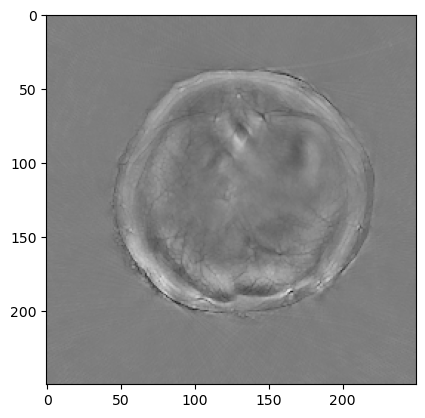

In [5]:
# 测试 多次运行查看是否存在标签错误
idx = np.random.randint(len(train_images))

plt.imshow(train_images[idx], cmap='gray', vmin=-10, vmax=10)
print(train_labels[idx])

In [6]:
# 创建数据集
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 数据增强
train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
])

# 创建完整数据集
train_test_dataset = ImageDataset(train_images, train_labels, transform=train_transform)
valid_dataset = ImageDataset(valid_images, valid_labels, transform=valid_transform)

In [7]:
# 随机划分训练集和测试集
train_size = int(0.7 * len(train_test_dataset) / 100) * 100
test_size = len(train_test_dataset) - train_size
train_dataset, test_dataset = random_split(train_test_dataset, [train_size, test_size])
print(len(train_dataset), len(test_dataset), len(valid_dataset))

5400 2400 2800


In [8]:
# 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# 测试数据加载器
for images, labels in train_loader:
    print(images.shape)
    # plt.imshow(images[2, 0], cmap='gray', vmin=-10, vmax=10)
    break

for images, labels in valid_loader:
    print(images.shape)
    # plt.imshow(images[2, 0], cmap='gray', vmin=-10, vmax=10)
    break

torch.Size([64, 1, 250, 250])
torch.Size([64, 1, 250, 250])


In [10]:
from vit_pytorch import SimpleViT
from CNN_net import *

# 清理GPU缓存
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net = NiN(in_channels=1).to(device)
net = SimpleViT(
    image_size=250,
    patch_size=25,
    num_classes=2,
    dim=256,
    depth=6,
    heads=8,
    mlp_dim=512,
    channels=1
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
print('net', net)

net SimpleViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=25, p2=25)
    (1): LayerNorm((625,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=625, out_features=256, bias=True)
    (3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Transformer(
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
          (to_out): Linear(in_features=512, out_features=256, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=256, out_features=512, bias=True)
            (2): GELU(approximate='none')
  

In [11]:
import time

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

history = {
    'Epoch': [],
    'Train Loss': [],
    'Test Accuracy': [],
    'Valid Accuracy': [],
}

num_epochs = 20
best_acc = 0
for epoch in range(num_epochs):
    time_start = time.time()
    net.train()
    # 训练数据集
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # 测试集
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        time_end = time.time() - time_start

        test_acc = correct / total
        print(f"Epoch {epoch + 1:02d}: "
              f"Train Loss    : {train_loss:6.3f}, "
              f"Time of train and test: {time_end:.2f}s")
        print(f"===== ==: Test  Accuracy: "
              f"{test_acc * 100:.2f}%,")

        history['Epoch'].append(epoch + 1)
        history['Train Loss'].append(train_loss)
        history['Test Accuracy'].append(test_acc * 100)

    # 验证集
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        valid_acc = correct / total
        print(f"===== ==: Valid Accuracy: "
              f"{valid_acc * 100:.2f}%, ")
        print("=" * 80)

        history['Valid Accuracy'].append(valid_acc * 100)

    if (test_acc + valid_acc) > best_acc:
        best_acc = test_acc + valid_acc
        torch.save(net.state_dict(), 'model/ViT.pth')

print(f'Best Accuracy: ' f'{best_acc * 100:.2f}%')

Epoch 01: Train Loss    : 74.104, Time of train and test: 4.39s
===== ==: Test  Accuracy: 52.96%,
===== ==: Valid Accuracy: 61.79%, 
Epoch 02: Train Loss    : 45.060, Time of train and test: 4.06s
===== ==: Test  Accuracy: 83.92%,
===== ==: Valid Accuracy: 84.89%, 
Epoch 03: Train Loss    : 18.562, Time of train and test: 4.06s
===== ==: Test  Accuracy: 92.42%,
===== ==: Valid Accuracy: 77.79%, 
Epoch 04: Train Loss    :  9.746, Time of train and test: 4.14s
===== ==: Test  Accuracy: 94.88%,
===== ==: Valid Accuracy: 84.89%, 
Epoch 05: Train Loss    :  5.136, Time of train and test: 4.04s
===== ==: Test  Accuracy: 94.08%,
===== ==: Valid Accuracy: 86.93%, 
Epoch 06: Train Loss    :  4.348, Time of train and test: 4.29s
===== ==: Test  Accuracy: 95.04%,
===== ==: Valid Accuracy: 84.11%, 
Epoch 07: Train Loss    :  1.856, Time of train and test: 4.11s
===== ==: Test  Accuracy: 90.08%,
===== ==: Valid Accuracy: 71.43%, 
Epoch 08: Train Loss    :  3.887, Time of train and test: 4.15s
=====

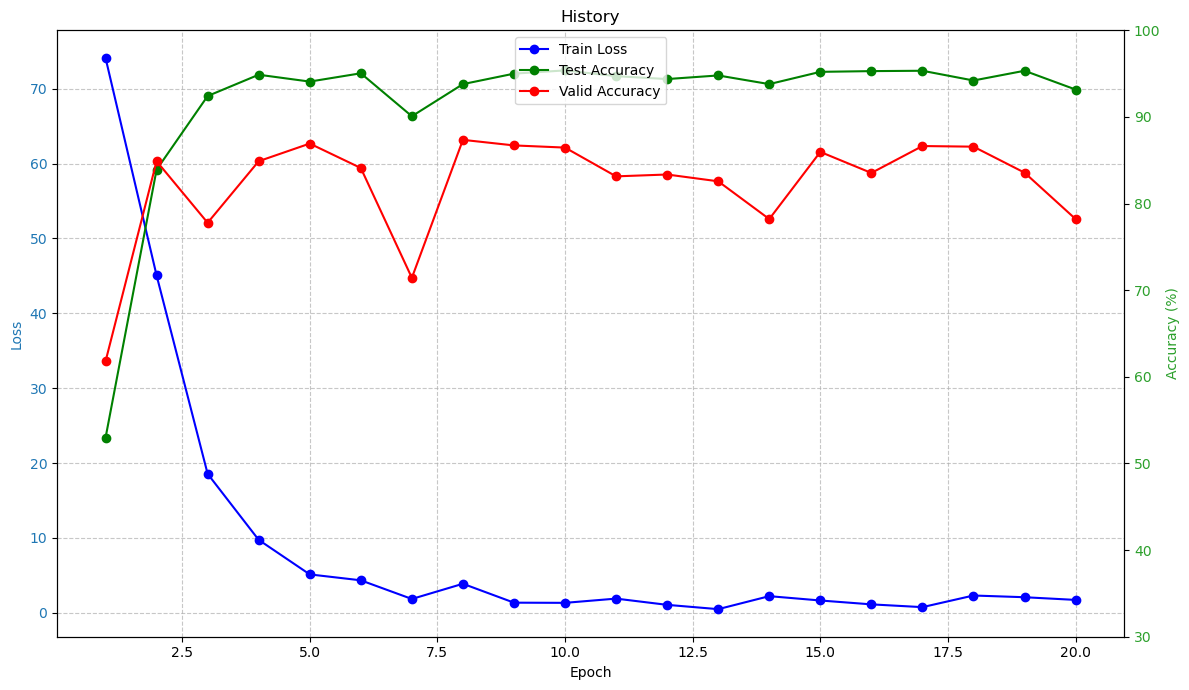

In [12]:
# 创建图形和主坐标轴(左侧纵轴对应损失)
fig, ax1 = plt.subplots(figsize=(12, 7))

# 绘制训练损失曲线(左侧纵轴)
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)

ax1.plot(history['Epoch'], history['Train Loss'], 'b-o', label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.7)

# 创建共享x轴的次坐标轴(右侧纵轴对应准确率)
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.set_ylim([30, 100])

# 绘制准确率曲线(右侧纵轴)
ax2.plot(history['Epoch'], history['Test Accuracy'], 'g-o', label='Test Accuracy')
ax2.plot(history['Epoch'], history['Valid Accuracy'], 'r-o', label='Valid Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# 添加标题
plt.title('History')

# 合并两个坐标轴的图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# TestNet = NiN().to(device)
TestNet = SimpleViT(
    image_size=250,
    patch_size=25,
    num_classes=2,
    dim=256,
    depth=6,
    heads=8,
    mlp_dim=512,
    channels=1
).to(device)
TestNet.load_state_dict(torch.load('model/ViT.pth'))

<All keys matched successfully>

In [15]:
# 记录转换函数
def find_transitions(tensor):
    if tensor.numel() == 0:
        return []

    tensor = tensor.flatten()
    elements = tensor.tolist()

    if all(x == 0 for x in elements) or all(x == 1 for x in elements):
        return []

    transitions = []
    prev = elements[0]

    for i in range(1, len(elements)):
        current = elements[i]
        if current != prev:
            if 3 < i < 16:
                transitions.append(i)
            prev = current

    return transitions

# 选择输入模型的验证集
num_valid = 4
file_path = os.path.join(file_dir, valid_npy_list[num_valid])
print(file_path)

dict = np.load(file_path, allow_pickle=True).item()
images_valid = dict['images']
images_valid = images_valid.reshape(-1, 20, 250, 250)

# 归一化
mean = np.mean(images_valid)
std = np.std(images_valid)
images_valid = (images_valid - mean) / std

with torch.no_grad():
    results = []
    for i in range(images_valid.shape[0]):
        test_imgs = images_valid[i]
        test_imgs = torch.from_numpy(test_imgs).unsqueeze(1).to(device)
        test_output = TestNet(test_imgs)
        # test_output = net(test_imgs)
        _, predicted = torch.max(test_output, 1)
        results.append(find_transitions(predicted))

print(results)

flatten = []
for result in results:
    if len(result) == 1:
        flatten.extend(result * 3)
    else:
        flatten.extend(result)

print(f"SOS Index Mean: {np.mean(flatten):.4f}")
print(f"SOS Index Std : {np.std(flatten):.4f}")
print(f"SOS Prediction: {np.mean(flatten) * 5 + 1450:.4f}")

../data/data_1450_1550_5ms\D12305.npy
[[11, 12, 13], [9, 10, 11], [10], [13], [13], [11], [11], [12], [12], [11], [12], [12], [11], [11], [12], [12], [11], [11], [11], [12], [11], [11], [12], [11], [11], [11], [11], [11], [11], [12], [11], [10], [11], [10], [10], [4, 5, 10], [11], [5, 6, 11], [5, 6, 11], [4, 5, 11], [12], [12], [10], [11], [11], [10], [11], [11], [11], [11], [10], [4, 5, 11], [4, 5, 11], [9], [4, 5, 10], [11], [10], [7, 8, 9], [6, 7, 9], [9]]
SOS Index Mean: 10.4444
SOS Index Std : 1.9471
SOS Prediction: 1502.2222
